# Handwriting PCA Gaussian Analysis

TJ Kim <br/>
4/13/21

Updated <br/>
4/13/21

#### Objective: 
For specific users bring all data points for specific MNIST label (not FEMNIST) and compare handwriting distribution. <br/>

Deliverables
- Plot PCA top 2 dimension for a couple of users for an mnist class with much data
- Run the PCA magnitude difference for the specific user class.

In [1]:
cd '/home/ubuntu/FedAtk/' 

/home/ubuntu/FedAtk


### Load Relevant Libraries and Modules

Load the relevant libraries for the federated learning code.

In [87]:
from transfer_attacks.DA_Transferer import *

import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import csv
import os
import pickle
from torch.autograd import Variable
import copy
import pandas as pd

import itertools

### Load Model and Data

In [3]:
# Make directory in results for this experiment
# FL Architecture
client_idx = 0
victim_idxs = [0]
# ifgsm_iterations = [10]
# batch_size = 1000

# Saved Neural Networks to Test on 
exp_names = ["exp4_neck2_0_head3"]

In [4]:
transferer = DA_Transferer(filename = exp_names[0])
transferer.generate_advNN(client_idx = client_idx)
transferer.generate_victims(client_idxs = victim_idxs)
transferer.load_niid_data(clients=victim_idxs)

Loading  all_data_12_niid_0_keep_0_train_9.json
Loading  all_data_20_niid_0_keep_0_train_9.json
Loading  all_data_11_niid_0_keep_0_train_9.json
Loading  all_data_18_niid_0_keep_0_train_9.json


/home/ubuntu/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


### Pick Specific Labels and load that data for analysis

The desired label is MNIST digit 1. This is also class 1 within the dataset.
We will load u = 10 users separately and analyze their data.

In [102]:
subject_class = 1
subject_client = 0
target_users = 5
label_freq_threshold = 14
target_usr_idx = range(target_users)

In [103]:
transferer.mode = 'client'
transferer.client_idxs = target_usr_idx
transferer.classes = subject_class
transferer.DA_x = {} # Reset
transferer.DA_y = {}

# Manually set the data as "both" for easy analysis
loader = transferer.loader_i[subject_client]

count = 0
for writer in loader.train_dataset['user_data'].keys():
    y = np.array(loader.train_dataset['user_data'][writer]['y'])
    cnt = np.argwhere(y==subject_class).shape[0]
    cidx = np.argwhere(y==subject_class).ravel()
    
    if count >= target_users:
        break
    elif cnt < label_freq_threshold:
        continue 
    else:
        count += 1
    
    y_class = torch.Tensor(y[cidx])
    x_class =  torch.Tensor(np.array(loader.train_dataset['user_data'][writer]['x'])[cidx]).reshape(cnt,1,28,28)

    transferer.DA_x[count-1] = x_class
    transferer.DA_y[count-1] = y_class

In [104]:
transferer.forward_pass()

### Print real images for each client
Observe how the handwritings are different.
Plot the first 5 images of any user.

client 0


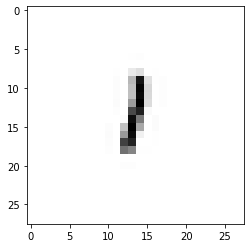

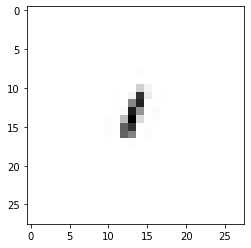

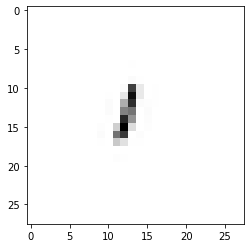

client 1


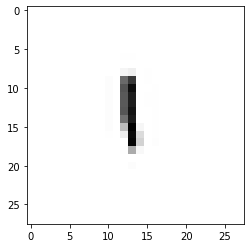

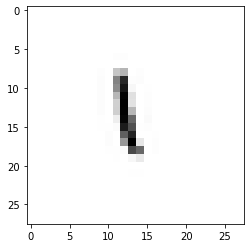

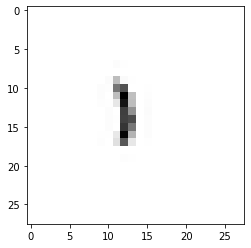

client 2


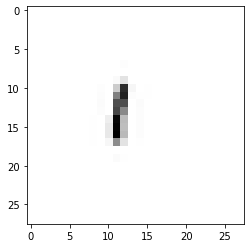

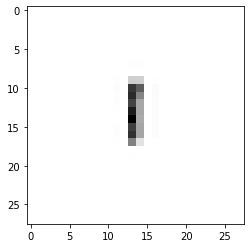

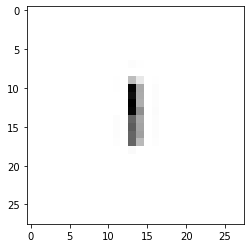

client 3


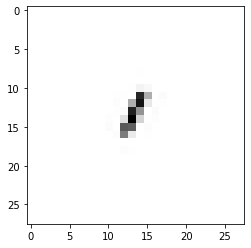

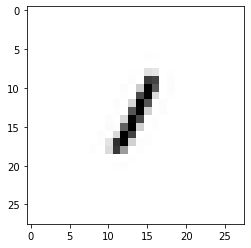

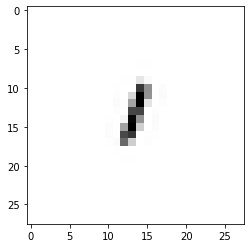

client 4


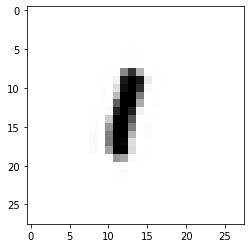

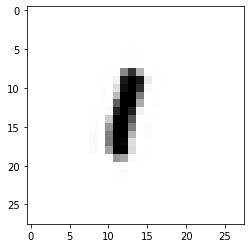

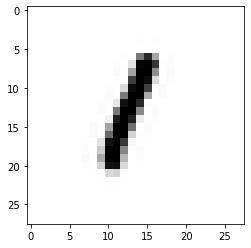

In [155]:
for i in range(5):
    data = np.array(transferer.DA_x[i])
    data = data.reshape([data.shape[0],28,28])
        
    print("client",i)
    for j in range(3):
        pixels = data[j]
        plt.imshow(pixels, cmap='gray')
        plt.show()


### Gaussian Analysis

Run cross-gaussian analysis from source-subject pairs (10x10) l2 difference.

In [106]:
transferer.obtain_gaussian()

In [108]:
# Build logging mechanism for pd output
gaussian_mean_L2 = np.zeros([target_users,target_users])
for (i,j) in itertools.product(range(target_users),range(target_users)):
    means_i = transferer.gaussian_ustd[i]['mean']
    means_j = transferer.gaussian_ustd[j]['mean']
    norm = torch.norm(means_i - means_j).cpu().detach().numpy()
    
    if (gaussian_mean_L2[i,j] == 0) and (i!=j):
        gaussian_mean_L2[i,j] = norm
        gaussian_mean_L2[j,i] = norm

In [110]:
df4 = pd.DataFrame(data=gaussian_mean_L2).T
print("L2 norm at convolution x2 output")
df4

L2 norm at convolution x2 output


,0,1,2,3,4
0,0.000000,5.739094,2.898032,4.609812,15.270419
1,5.739094,0.000000,5.355856,7.362886,15.076016
2,2.898032,5.355856,0.000000,5.703832,15.671403
3,4.609812,7.362886,5.703832,0.000000,12.844029
4,15.270419,15.076016,15.671403,12.844029,0.000000


### PCA Analysis

Run PCA analysis on all 10 clients and plot their differences. <br/>
Run L2 norm difference for deeper dimensions as well.

In [113]:
transferer.obtain_PCA(analyze_atk = False, advrobust_idx = 1, dim=2)

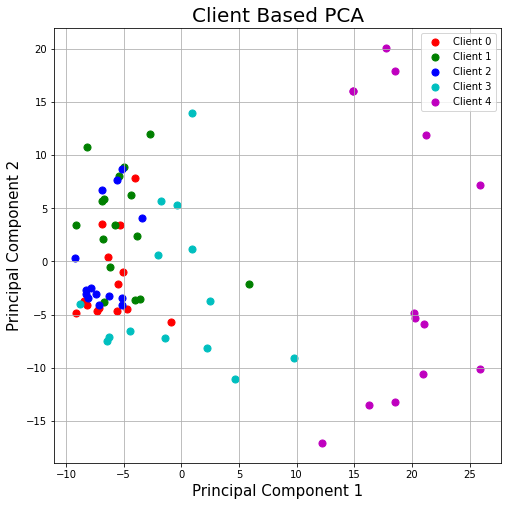

In [116]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Client Based PCA', fontsize = 20)


target_labels = ['Client 0', 'Client 1','Client 2','Client 3','Client 4',]
targets = range(5)
colors = ['r', 'g', 'b','c','m']
for target, color in zip(targets,colors):
    idx_temp0 = transferer.PCA_data['labels'][:,0] == target
    indicesToKeep = idx_temp0

    ax.scatter(transferer.PCA_data['data'][indicesToKeep,0]
               , transferer.PCA_data['data'][indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(target_labels)
ax.grid()

In [117]:
transferer.explained_var_ratio

array([0.25937963, 0.14853952])

Run the L2 difference across many dimensions.
Set client 0 as basis and run all other clients.

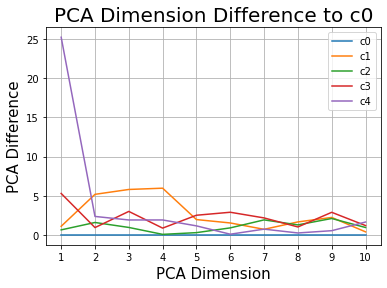

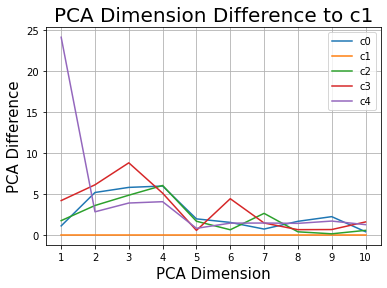

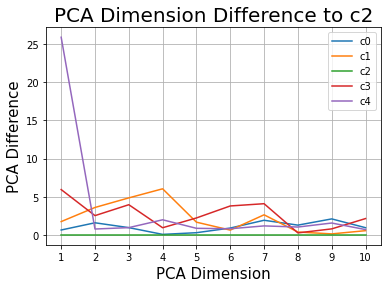

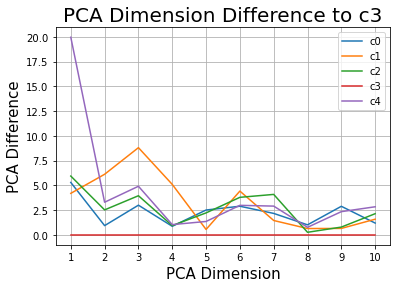

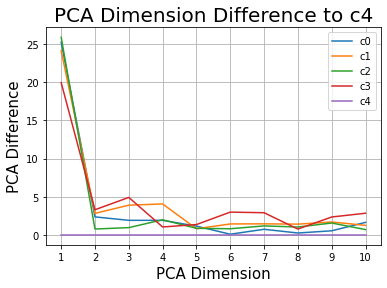

In [137]:
num_PCA_dim = 10
filtered_data = {}
transferer.obtain_PCA(analyze_atk = False, advrobust_idx = 1, dim=num_PCA_dim)

# Data Sorting
for i in range(5): 
    idx_temp0 = transferer.PCA_data['labels'][:,0] == i
    indicesToKeep = idx_temp0

    filtered_data[i] = transferer.PCA_data['data'][indicesToKeep]

# Plotting
dim_axis = np.arange(num_PCA_dim) + 1
for j in range(5):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('PCA Dimension', fontsize = 15)
    ax.set_ylabel('PCA Difference', fontsize = 15)
    ax.set_title('PCA Dimension Difference to c' + str(j), fontsize = 20)


    for i in range(5): 
        diff_pca = np.abs(np.mean(filtered_data[i],axis=0) - np.mean(filtered_data[j],axis=0))
        ax.plot(dim_axis,diff_pca,label='c'+str(i))
        ax.legend()
        ax.set_xticks(dim_axis)
        ax.grid()